## Solving MDP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class particle:
    def __init__(self, m=1, pc=0.3, pw=0.3, ymax=2, vmax=2, f_phi=lambda y: -2*np.cos(y)):
        self.m = m
        self.pc = pc
        self.pw = pw
        self.f_phi = f_phi
        self.ymax = ymax
        self.vmax = vmax

    def T(self, y, v, fi):
        '''
        Calculate the transition probability
        Input:
            y: float, position
            v: float, velocity
            fi: float, input force
        Output:
            states: array, an array of possible state
            probs: array, an array of probabilities of arriving at the states
        '''
        y += v
        v += (1 / self.m) * (fi + self.f_phi(y))

        y = np.clip(y, -self.ymax, self.ymax)
        v = np.clip(v, -self.vmax, self.vmax)

        states = np.array([
            [y, max(v-1, -self.vmax)],
            [y, v],
            [y, min(v+1, self.vmax)],
            [y, 0]  , [y, 0], [y, 0]])

        wobble_prob = np.array([
            abs(v)/self.vmax*self.pw/2,
            1-abs(v)/self.vmax*self.pw,
            abs(v)/self.vmax*self.pw/2
        ])

        crash_prob = np.array([
            1-abs(v)/self.vmax*self.pc,
            abs(v)/self.vmax*self.pc
        ])

        probs = (crash_prob[:,np.newaxis] @ wobble_prob[np.newaxis,:]).flatten()
        return states, probs

    def value_iteration(self, goal=(0,0), gamma=0.99, c=0, delta=1e-3):
        '''
        Value iteration to find the optimal policy
        Input:
            goal: goal state of the system in which you will receive reward 1
            gamma: time discount fater
            c: fuel consumption for each non-zero fi
            delta: stopping criteria
        Output:
            V: array, value function given state
            policy: array, optimal policy given state
        '''
        def state2id(y, v):
            return np.rint(y+self.ymax).astype(int), np.rint(v+self.vmax).astype(int)

        def R(s_not, a, s):
            return np.array([np.array_equal(si, goal) for si in s_not]) - np.abs(a)*c

        state_shape = (2*self.ymax+1, 2*self.vmax+1)
        V = np.zeros(state_shape)
        policy = np.zeros(state_shape)

        A = np.array([-1, 0, 1])  # action space
        for _ in range(1000):
            V_old = V.copy()
            for y in range(-self.ymax, self.ymax+1):
                for v in range(-self.vmax, self.vmax+1):

                    def v_not_plus_r(a):
                        s, p = self.T(y, v, a)
                        sid = state2id(s[:,0], s[:,1])
                        v_not_plus_r = gamma*V[sid] + R(s, a, (y, v))
                        return np.sum(v_not_plus_r * p)

                    E_v_not_plus_r = np.array([v_not_plus_r(a) for a in A])

                    V[state2id(y, v)] = np.max(E_v_not_plus_r)
                    policy[state2id(y, v)] = A[np.argmax(E_v_not_plus_r)]
                    V[state2id(goal[0], goal[1])] = 0  # always set the goal state to have zero value

            # early stopping
            if np.linalg.norm(V_old - V, ord=np.inf) < delta:
                break
        return V, policy

    def policy_iteration(self, goal=(0,0), gamma=0.5, c=0.2, delta=1e-3):
        '''
        Value iteration to find the optimal policy
        Input:
            goal: goal state of the system in which you will receive reward 1
            gamma: time discount fater
            c: fuel consumption for each non-zero fi
            delta: stopping criteria
        Output:
            V: array, value function given state
            policy: array, optimal policy given state
        '''

        def state2id(y, v):
            return np.rint(y+self.ymax).astype(int), np.rint(v+self.vmax).astype(int)

        def R(s_not, a, s):
            return np.array([np.array_equal(si, goal) for si in s_not]) - np.abs(a)*c

        state_shape = (2*self.ymax+1, 2*self.vmax+1)
        V = np.zeros(state_shape)
        policy = np.zeros(state_shape)
        A = np.array([-1, 0, 1])

        def v_not_plus_r(y, v, a):
            s, p = self.T(y, v, a)
            sid = state2id(s[:,0], s[:,1])
            v_not_plus_r = gamma*V[sid] + R(s, a, (y, v))
            return np.sum(v_not_plus_r * p)

        def policy_evaluation():
            for _ in range(1000):
                V_old = V.copy()
                for y in range(-self.ymax, self.ymax+1):
                    for v in range(-self.vmax, self.vmax+1):
                        V[state2id(y, v)] = v_not_plus_r(y, v, policy[state2id(y, v)])
                        V[state2id(goal[0], goal[1])] = 0  # always set the goal state to have zero value

                if np.linalg.norm(V_old - V, ord=np.inf) < delta:
                    break

        def policy_improvement():
            policy_stable = False
            while not policy_stable:
                policy_stable = True
                for y in range(-self.ymax, self.ymax+1):
                    for v in range(-self.vmax, self.vmax+1):
                        pi = policy[state2id(y, v)]
                        E_v_not_plus_r = np.array([v_not_plus_r(y, v, a) for a in A])
                        pi_new = A[np.argmax(E_v_not_plus_r)]
                        policy[state2id(y, v)] = pi_new
                        if pi != pi_new:
                            policy_stable = False

        V_old = V.copy()
        for _ in range(1000):
            policy_evaluation()
            if np.linalg.norm(V_old - V, ord=np.inf) < delta:
              break
            V_old = V.copy()
            policy_improvement()

        return V, policy

    def simulate_trajectory(self, y0, v0, policy, goal=(0,0), max_steps=30):
        '''
        Simulate the particle trajectory using the optimal policy.
        '''
        y, v = y0, v0
        trajectory = [(y, v)]
        forces = []  # List to record forces at each time step

        for _ in range(max_steps):
            y_id, v_id = int(np.rint(y + self.ymax)), int(np.rint(v + self.vmax))
            fi = policy[y_id, v_id]
            forces.append(fi)  # Record the applied force

            states, probs = self.T(y, v, fi)
            next_state_idx = np.random.choice(len(states), p=probs)
            y, v = states[next_state_idx]

            trajectory.append((y, v))
            if np.allclose((y, v), goal):
              break

        return np.array(trajectory), np.array(forces)

In [ ]:
ymax = 8
vmax = 8
pc = 0.1
pw = 0.3
A = 1
c = 0

p = particle(ymax=ymax, vmax=vmax, pc=pc, pw=pw, f_phi=lambda y: int(A*np.sin(2*np.pi*y/ymax)))
value, policy = p.value_iteration(c=c, gamma=0.9)

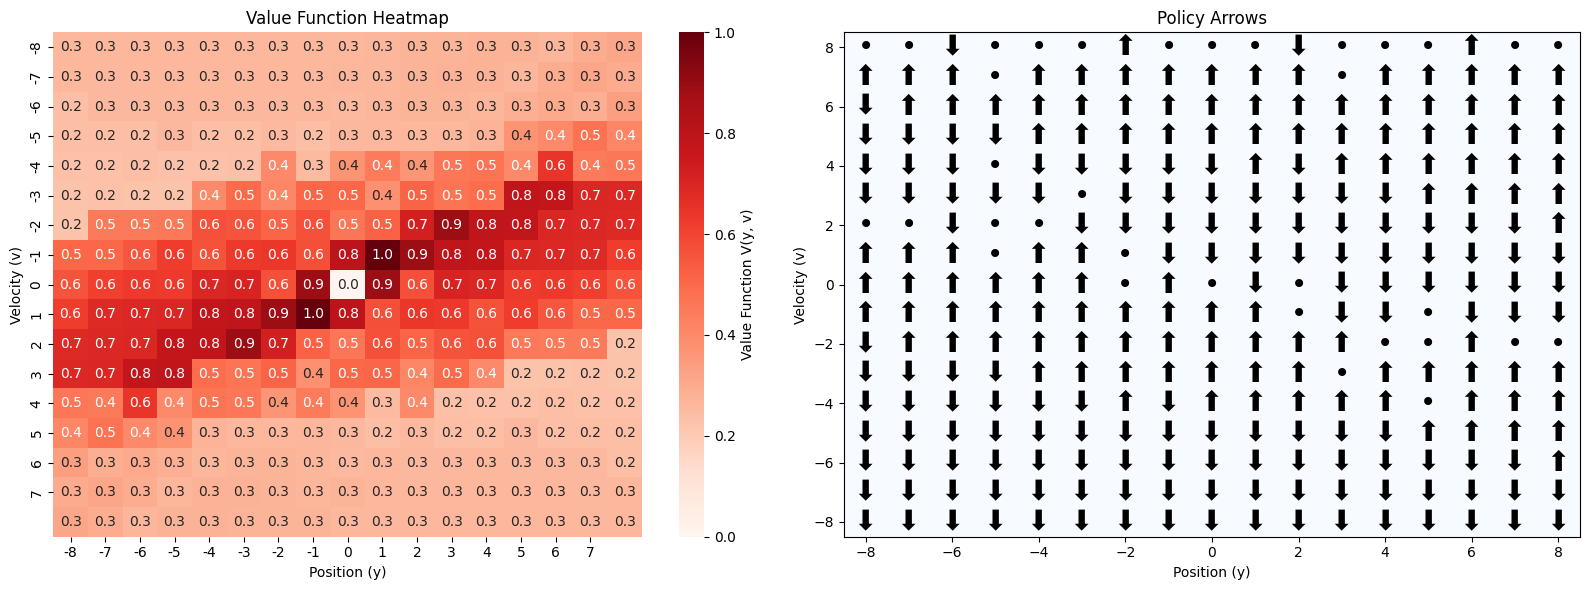

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(value.T, annot=True, fmt=".1f", cmap='Reds', cbar_kws={'label': 'Value Function V(y, v)'},
            xticklabels=range(-p.ymax, p.ymax), yticklabels=range(-p.vmax, p.vmax), ax=axes[0])

axes[0].set_xlabel('Position (y)')
axes[0].set_ylabel('Velocity (v)')
axes[0].set_title('Value Function Heatmap')

axes[1].set_xlabel('Position (y)')
axes[1].set_ylabel('Velocity (v)')
axes[1].set_title('Policy Arrows')

extent = [-p.ymax-0.5, p.ymax+0.5, -p.vmax-0.5, p.vmax+0.5]
axes[1].imshow(np.zeros_like(policy.T), origin='lower', extent=extent, aspect='auto', cmap='Blues')

nrows, ncols = policy.shape
for i in range(nrows):
    for j in range(ncols):
        if policy[i, j] == -1:
            arrow = '⬇️'
        elif policy[i, j] == 1:
            arrow = '⬆️'
        else:
            arrow = '•'

        axes[1].text(i - p.ymax, j - p.vmax, arrow, ha='center', va='center', fontsize=20, color='black')

# Display the plots
plt.tight_layout()
plt.show()

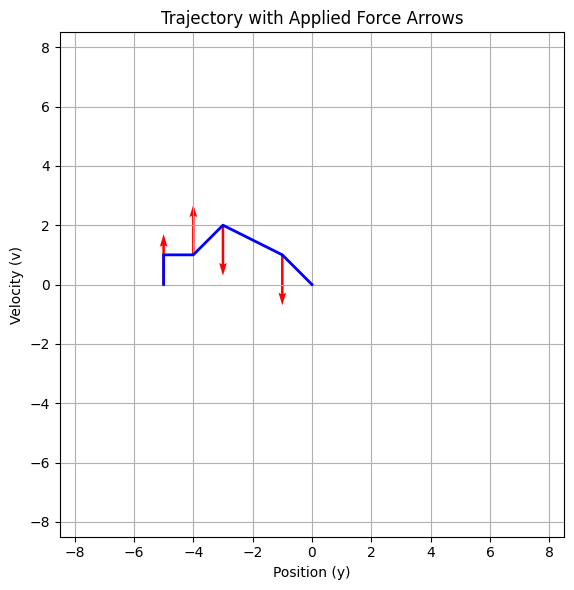

In [ ]:
trajectory, force = p.simulate_trajectory(-5, 0, policy)

y_vals = trajectory[:, 0]
v_vals = trajectory[:, 1]

plt.figure(figsize=(10, 6))

plt.plot(y_vals, v_vals, color='blue', lw=2)

for i in range(len(force)):
    x_pos = y_vals[i]
    y_pos = v_vals[i]

    if force[i] == -1:
        dy, dx = -1, 0
    elif force[i] == 1:
        dy, dx = 1, 0
    else:
        dx, dy = 0, 0

    # Plot the arrow at the trajectory point
    plt.quiver(x_pos, y_pos, dx, dy, scale=10, color='red', width=0.005)

plt.xlim(-p.ymax-0.5, p.ymax+0.5)
plt.ylim(-p.vmax-0.5, p.vmax+0.5)
plt.gca().set_aspect('equal')
plt.xlabel('Position (y)')
plt.ylabel('Velocity (v)')
plt.title('Trajectory with Applied Force Arrows')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
ymax = 8
vmax = 8
pc = 0.1
pw = 0.3
A = 1
c = 0.1

p = particle(ymax=ymax, vmax=vmax, pc=pc, pw=pw, f_phi=lambda y: int(A*np.sin(2*np.pi*y/ymax)))
value, policy = p.policy_iteration(c=c, gamma=0.9)

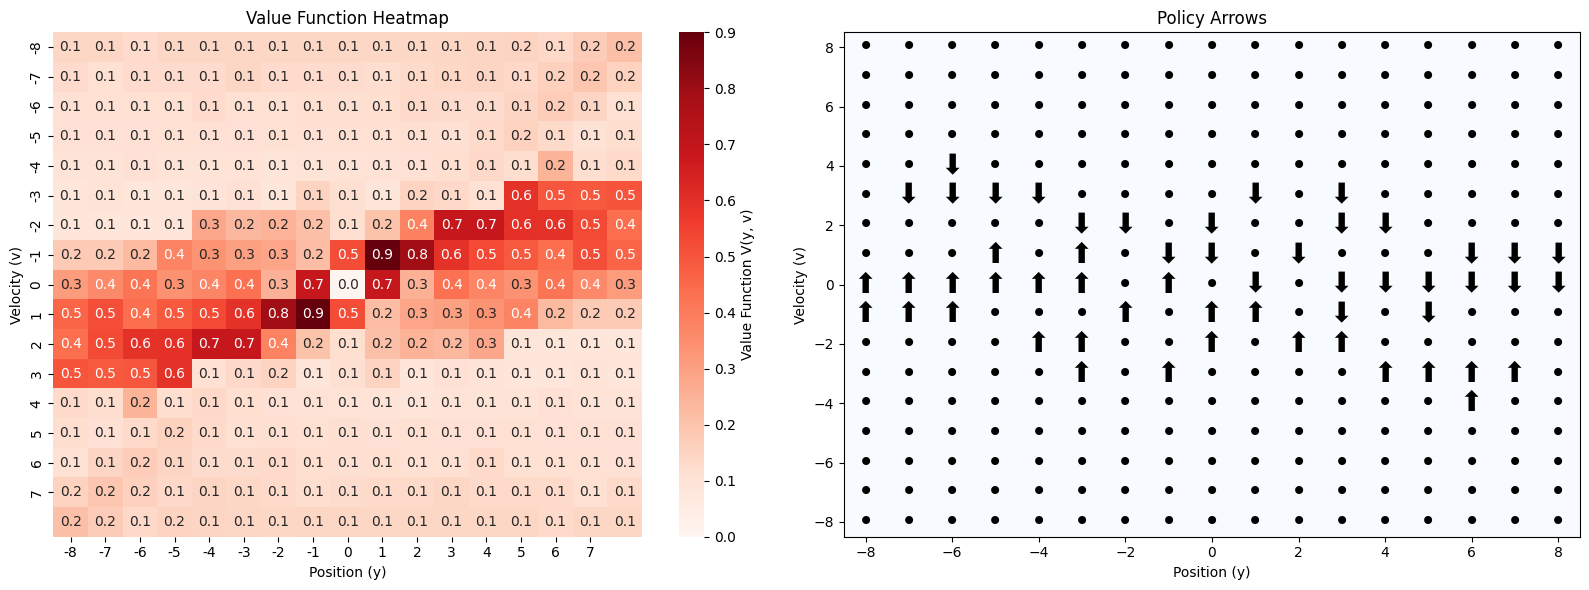

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(value.T, annot=True, fmt=".1f", cmap='Reds', cbar_kws={'label': 'Value Function V(y, v)'},
            xticklabels=range(-p.ymax, p.ymax), yticklabels=range(-p.vmax, p.vmax), ax=axes[0])

axes[0].set_xlabel('Position (y)')
axes[0].set_ylabel('Velocity (v)')
axes[0].set_title('Value Function Heatmap')

axes[1].set_xlabel('Position (y)')
axes[1].set_ylabel('Velocity (v)')
axes[1].set_title('Policy Arrows')

extent = [-p.ymax-0.5, p.ymax+0.5, -p.vmax-0.5, p.vmax+0.5]
axes[1].imshow(np.zeros_like(policy.T), origin='lower', extent=extent, aspect='auto', cmap='Blues')

nrows, ncols = policy.shape
for i in range(nrows):
    for j in range(ncols):
        if policy[i, j] == -1:
            arrow = '⬇️'
        elif policy[i, j] == 1:
            arrow = '⬆️'
        else:
            arrow = '•'

        axes[1].text(i - p.ymax, j - p.vmax, arrow, ha='center', va='center', fontsize=20, color='black')

# Display the plots
plt.tight_layout()
plt.show()

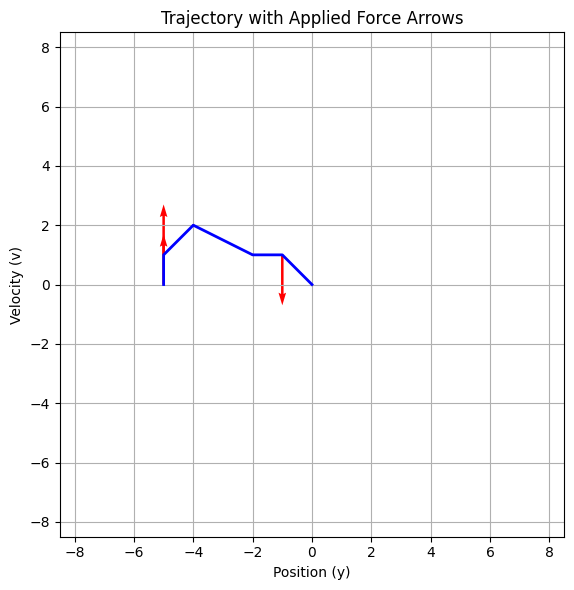

In [ ]:
trajectory, force = p.simulate_trajectory(-5, 0, policy)

y_vals = trajectory[:, 0]
v_vals = trajectory[:, 1]

plt.figure(figsize=(10, 6))

plt.plot(y_vals, v_vals, color='blue', lw=2)

for i in range(len(force)):
    x_pos = y_vals[i]
    y_pos = v_vals[i]

    if force[i] == -1:
        dy, dx = -1, 0
    elif force[i] == 1:
        dy, dx = 1, 0
    else:
        dx, dy = 0, 0

    # Plot the arrow at the trajectory point
    plt.quiver(x_pos, y_pos, dx, dy, scale=10, color='red', width=0.005)

plt.xlim(-p.ymax-0.5, p.ymax+0.5)
plt.ylim(-p.vmax-0.5, p.vmax+0.5)
plt.gca().set_aspect('equal')
plt.xlabel('Position (y)')
plt.ylabel('Velocity (v)')
plt.title('Trajectory with Applied Force Arrows')
plt.grid(True)

plt.tight_layout()
plt.show()